<a href="https://colab.research.google.com/github/pietromarini00/30412-Classification-with-LogisticRegression/blob/main/Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCRIPTON


----------

This dataset is composed of 1200 samples with 35 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 5 possible values for the labels. The remaining columns are numeric
features.

Your task is the following: assuming that you want to classify this data with
Logistic Regression (implemented by sklearn.linear_model.LogisticRegression),
you should determine whether applying PCA to this dataset is useful, and if so
what number of components you would choose to use. At the end of the analysis,
you should have chosen an optimal strategy, including the optimal set of
parameters for the classifier: write this choice explicitly in the conclusions
of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

# Import Packages and Data

In [183]:
import pandas as pd
import numpy as np

from scipy.stats import loguniform

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import LSTM


Data = pd.read_csv('mldata_0003094072.csv')

# Data Visualization and Exploratory Analysis

In [184]:
labels = Data['label']
features = Data.drop(columns=['Unnamed: 0','label'])

In [185]:
features.isnull().any()

feature_1     False
feature_2     False
feature_3     False
feature_4     False
feature_5     False
feature_6     False
feature_7     False
feature_8     False
feature_9     False
feature_10    False
feature_11    False
feature_12    False
feature_13    False
feature_14    False
feature_15    False
feature_16    False
feature_17    False
feature_18    False
feature_19    False
feature_20    False
feature_21    False
feature_22    False
feature_23    False
feature_24    False
feature_25    False
feature_26    False
feature_27    False
feature_28    False
feature_29    False
feature_30    False
feature_31    False
feature_32    False
feature_33    False
feature_34    False
feature_35    False
dtype: bool

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


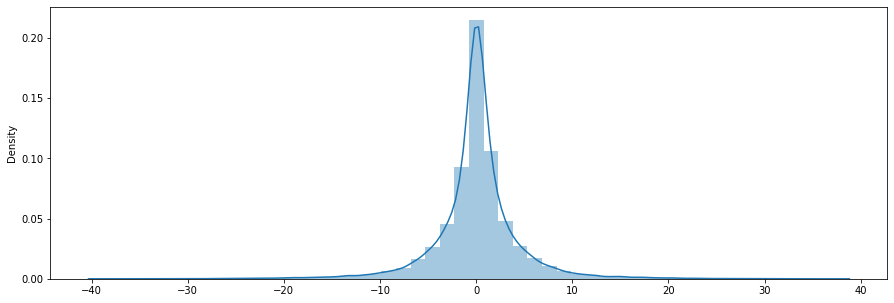

In [186]:
sns.distplot(features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f846066dd50>,
      dtype=object)

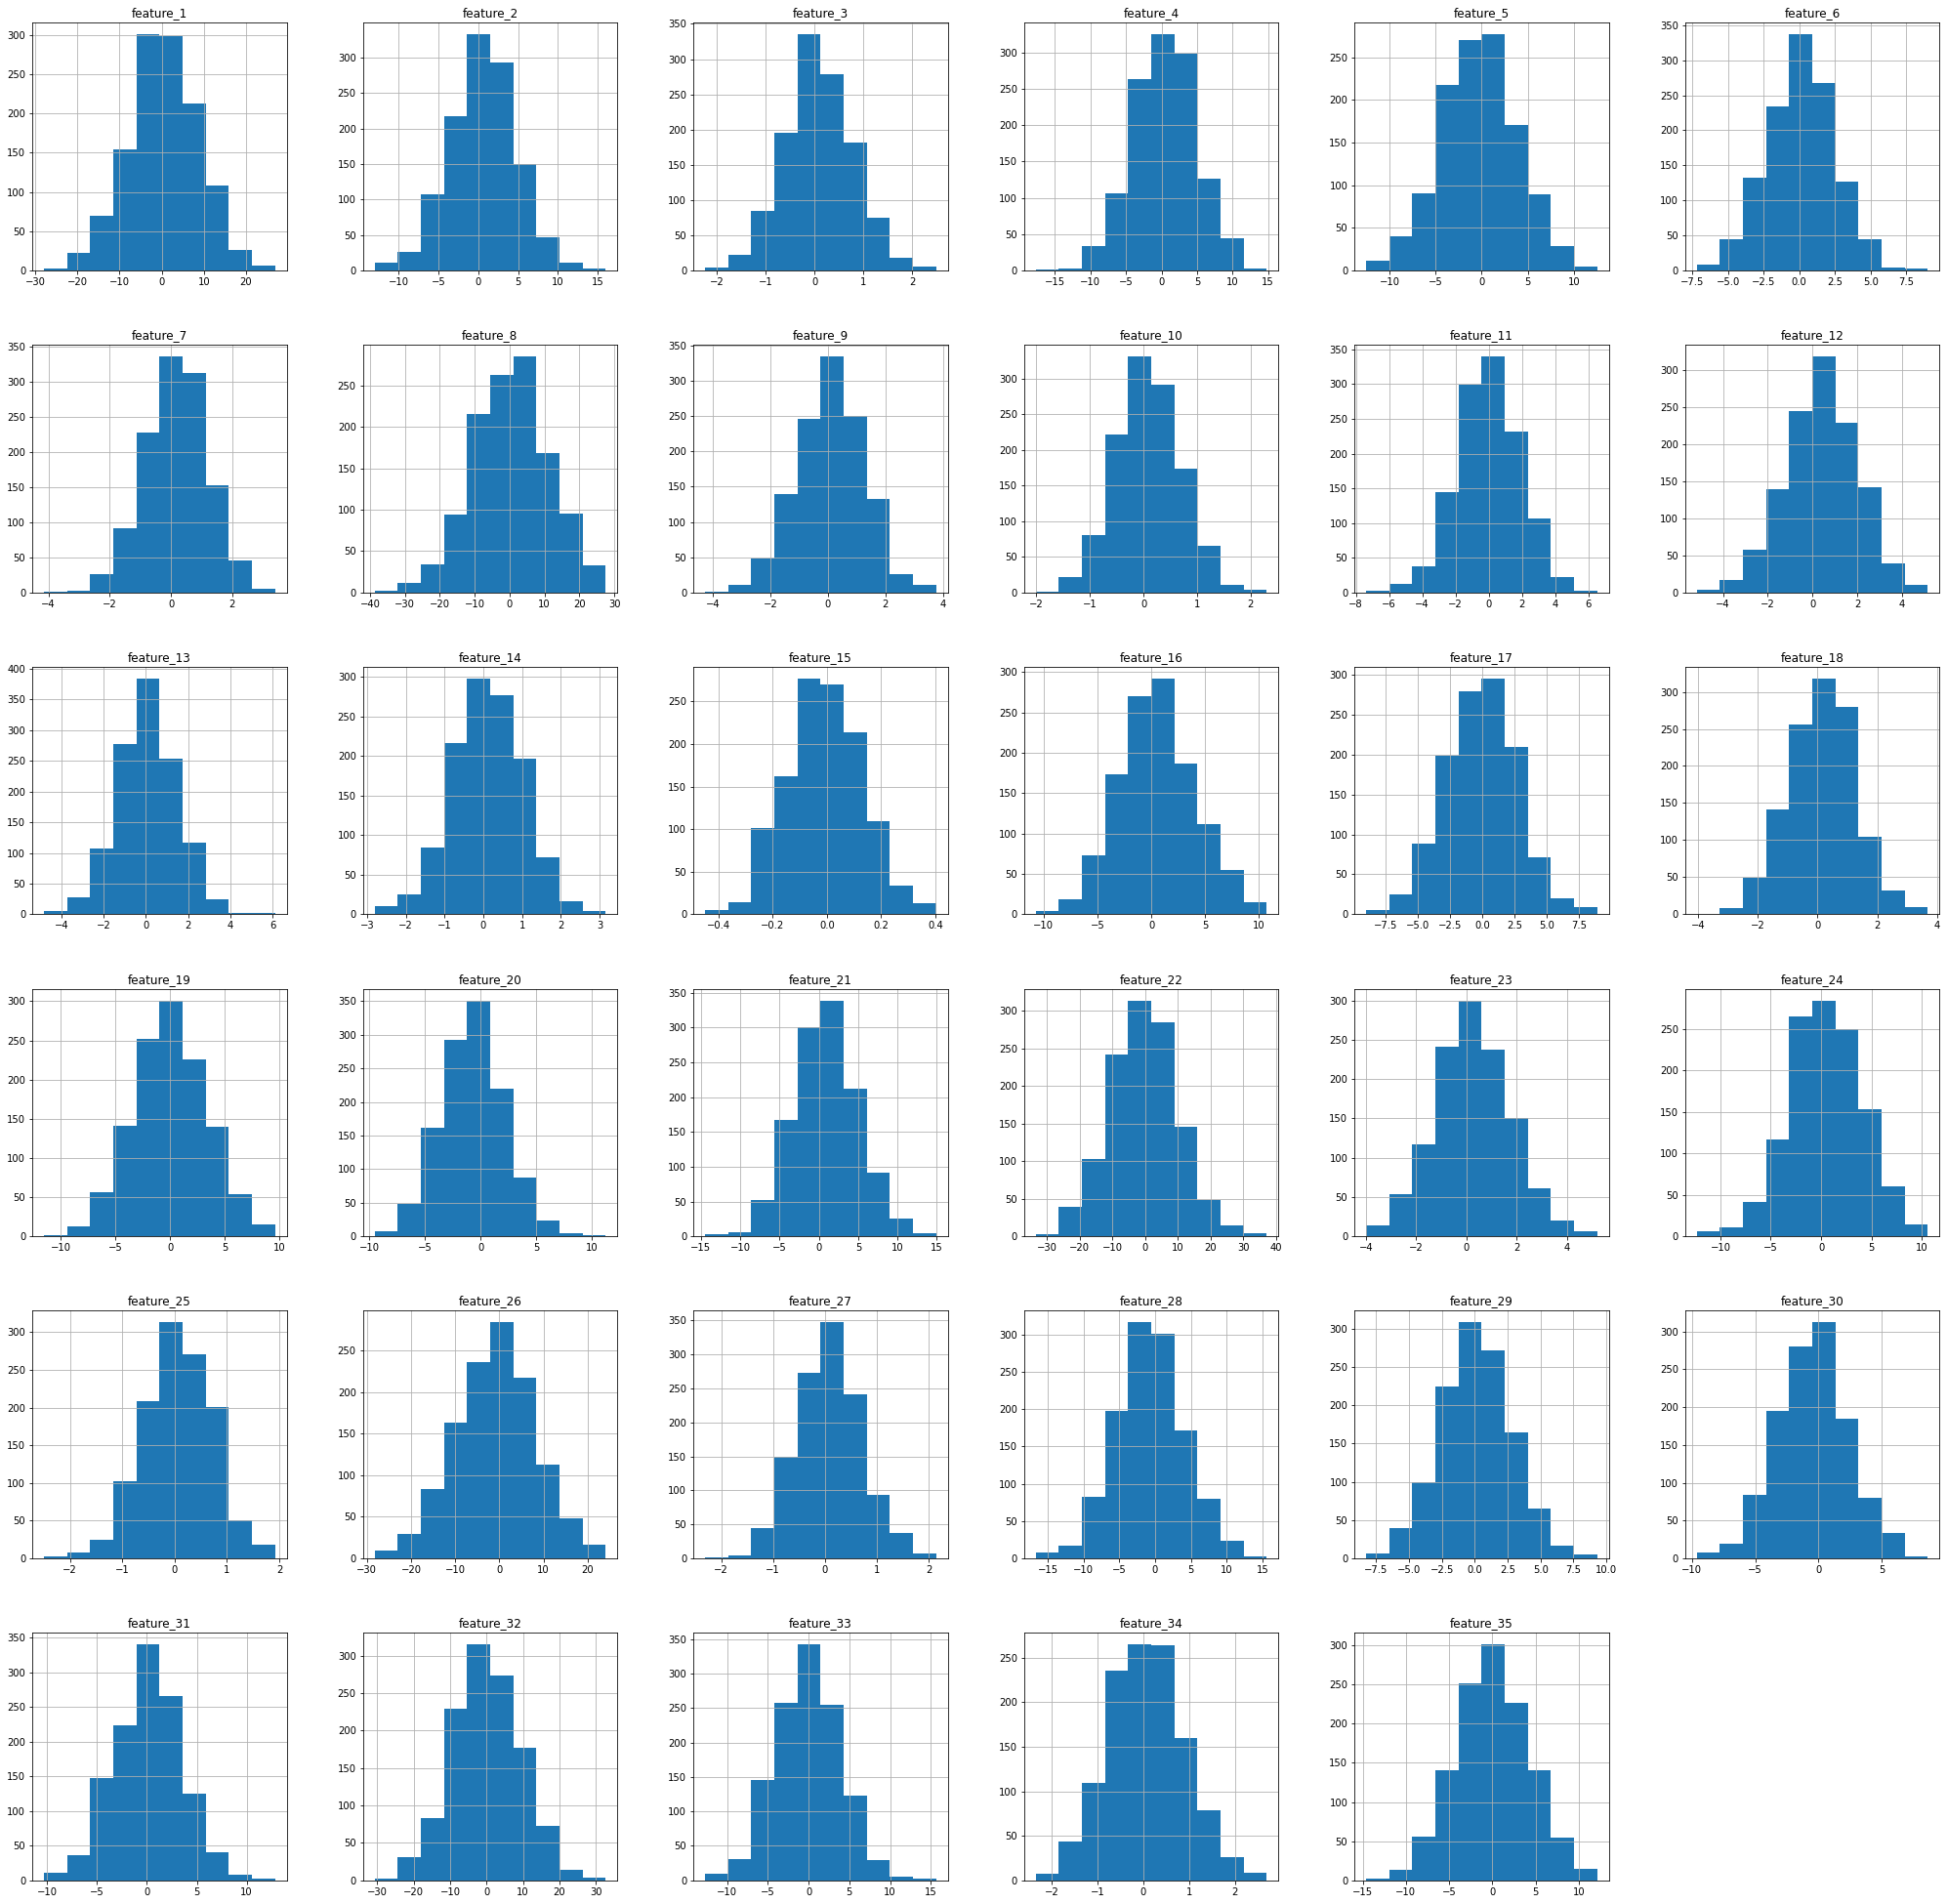

In [187]:
features.hist(figsize=(35,35))

Each feature already looks Normally distributed

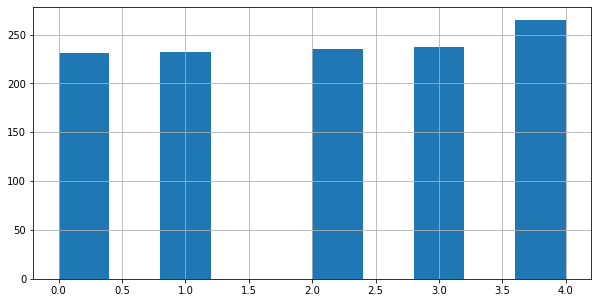

In [188]:
labels.hist(figsize=(10,5))

Classes are almost perfectly balanced, it is not really necessary to use stratified sampling, but we never know, so I tried it too, and found out it delivers very similar (but slightly worse) results
_______



In [189]:
#(Data.loc[Data['label'] == 2]).hist()


## Correlation Feature-Class

Now we are going to look at the correlation between each label and the features.
I want to have the labels One-Hot Encoded, so that they are more manageable for understanding correlation.
I wrote this function that takes a dataframe with Multiple Classes and One-Hot Encodes the labels





The function for calculating and displaying correlation is built on top of the previous one

In [190]:
from sklearn.preprocessing import OneHotEncoder

def One_Hot_label_dataframe(features,df):
  enc = OneHotEncoder(handle_unknown='ignore')
  enc_df = pd.DataFrame(enc.fit_transform(df[['label']]).toarray())
  df = df.join(enc_df).drop(columns=['Unnamed: 0','label'])
  return df

The color map of the feature-to-class correlation is centered at "yellow", so everything far from yellow has a higher absolute value correlation (meaning that it should be more informative on the class on the x-axis) 

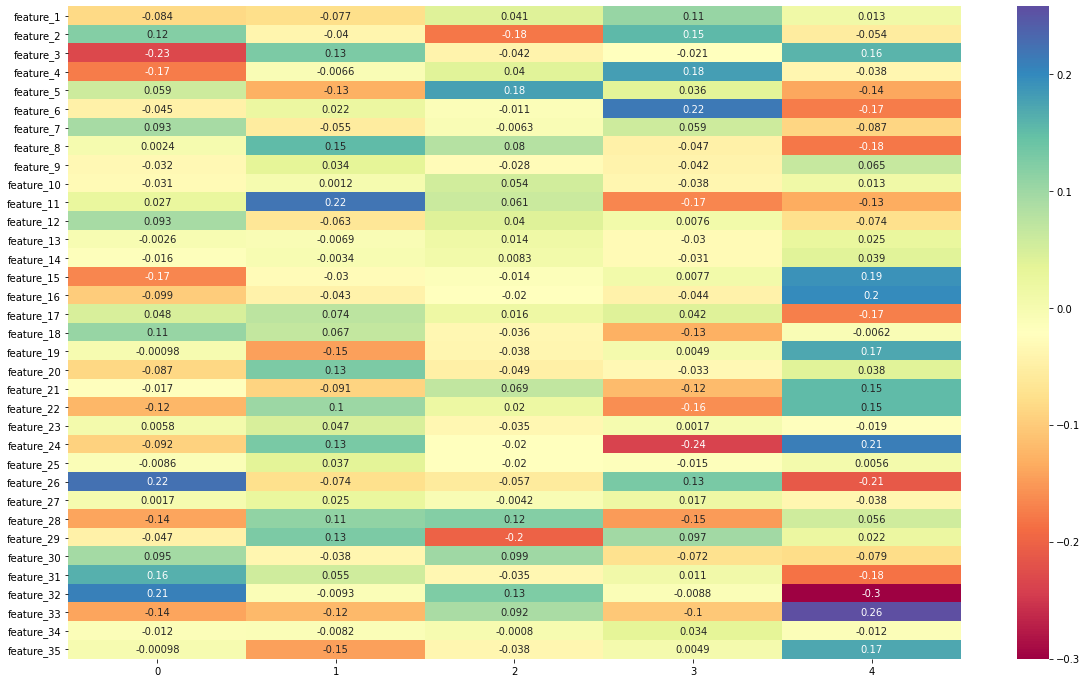

In [191]:
import seaborn as sns

def correlation(features,df):
  labels = sorted(df['label'].unique())
  df = One_Hot_label_dataframe(features,df)
  corr_matrix = df.corr()
  map = corr_matrix[labels][:'feature_35']
  fig, ax = plt.subplots(figsize=(20,12))
  sns.heatmap(map, annot=True,ax=ax,cmap='Spectral')
correlation(features,Data)

In [192]:
features.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,0.537747,0.599903,0.094714,0.437445,-0.287543,0.100894,0.157844,0.343041,0.083273,0.089775,-0.013457,0.407371,0.077296,0.110119,-0.009338,0.536562,-0.077199,0.155439,-0.008091,-0.714729,0.848633,-0.286941,0.249582,0.452351,0.067481,-0.831427,0.071756,-0.672589,0.124797,-0.452592,0.113184,0.045397,-0.119103,0.071709,-0.010214
std,8.280886,4.158050,0.694315,4.373206,4.068543,2.323017,1.008751,10.749965,1.160246,0.601856,1.917890,1.599477,1.397480,0.905573,0.138374,3.535027,2.755736,1.115841,3.352445,2.870847,4.090681,10.346132,1.500818,3.628688,0.657344,8.941232,0.623488,4.794596,2.670211,2.785172,3.394775,9.186563,3.940853,0.827774,4.232406
min,-27.927444,-12.994024,-2.235127,-17.719503,-12.543721,-7.197453,-4.146284,-38.740429,-4.272391,-2.014612,-7.379815,-5.174015,-4.817577,-2.806012,-0.450353,-10.732117,-9.000173,-4.038802,-11.559353,-9.549318,-14.475878,-33.538971,-3.989719,-12.359812,-2.494318,-28.280245,-2.309615,-16.699334,-8.255329,-9.632036,-10.322071,-30.754219,-12.693954,-2.348815,-14.593491
25%,-4.814249,-2.000171,-0.353134,-2.617755,-2.979183,-1.427281,-0.522847,-6.862036,-0.683507,-0.319334,-1.295812,-0.642718,-0.850135,-0.524722,-0.103660,-1.915450,-1.972813,-0.608140,-2.286750,-2.640615,-1.988146,-7.240400,-0.732849,-1.887101,-0.367372,-6.916969,-0.349212,-3.885086,-1.649932,-2.341065,-2.050383,-6.264539,-2.924524,-0.507311,-2.886984
50%,0.467960,0.838226,0.067960,0.578034,-0.320604,0.145843,0.189564,0.481231,0.062131,0.067138,-0.000821,0.411820,0.060772,0.116987,-0.013843,0.422070,-0.021565,0.180173,-0.021096,-0.749884,0.783918,-0.181956,0.210384,0.391307,0.071825,-0.639388,0.059726,-0.792753,0.157200,-0.432930,0.021544,-0.058583,-0.091578,0.063345,-0.026633
75%,6.106173,3.336066,0.565964,3.419695,2.462689,1.655129,0.805694,7.615251,0.871378,0.503978,1.251955,1.493330,0.975052,0.752544,0.087456,2.788507,1.815663,0.893509,2.340174,1.102171,3.549060,6.695453,1.301859,2.937969,0.544379,5.278754,0.463303,2.462328,1.888801,1.344736,2.434800,6.378856,2.525585,0.621703,2.954431
max,26.883436,15.971686,2.491952,14.810534,12.561359,9.019687,3.397375,27.545013,3.771634,2.302004,6.523992,5.160566,6.112456,3.159713,0.403436,10.723347,8.888041,3.690058,9.606745,11.275957,14.917117,37.235678,5.217805,10.610519,1.920238,24.104058,2.144743,15.611492,9.313357,8.662238,12.857374,32.736197,15.655862,2.689480,12.128355


# Preprocessing: Is Scaling Convenient?

Since the data is not standardized, maybe a scaling could improve the performance, we will try with and without

In [193]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

scalers = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), None]

we first run the model with default parameters to have a baseline for its performance. I used a pipeline to avoid using scaling the data before cross validation, thus taking the mean over the whole dataset, which would be incorrect since we don't know the value in the validation set yet

In [194]:
def scaling_effects(scalers,features,labels):  
  for scaler in scalers:
    model = LogisticRegression(max_iter=1000)
    pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, features, labels, cv = cv)
    print(f'Accuracy with {scaler}: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

scaling_effects(scalers,features,labels)

Accuracy with MinMaxScaler(copy=True, feature_range=(0, 1)): 0.525 (0.048)
Accuracy with MaxAbsScaler(copy=True): 0.526 (0.058)
Accuracy with StandardScaler(copy=True, with_mean=True, with_std=True): 0.527 (0.052)
Accuracy with None: 0.527 (0.052)


Since the features are already normal, the scaling doesn't impact that much the accuracy. Thus No Scaling or Standard Scaling is the best Option. \\
I will go for Standard Scaling, because it is necessary for PCA

In [195]:
X, y = Data.drop(columns=['Unnamed: 0','label']), labels
X = StandardScaler().fit_transform(X)

# Principal Component Analysis

https://towardsdatascience.com/think-twice-before-you-use-principal-component-analysis-in-supervised-learning-tasks-70fbb68ebd0c

https://www.nature.com/articles/nmeth.4346
___

PCA may serve for the following purposes:
- Visualization (if we can get it down to 2 or 3 dimensions), e.g. for exploratory data analysis 
- Reduce computational load
- Reduce noise


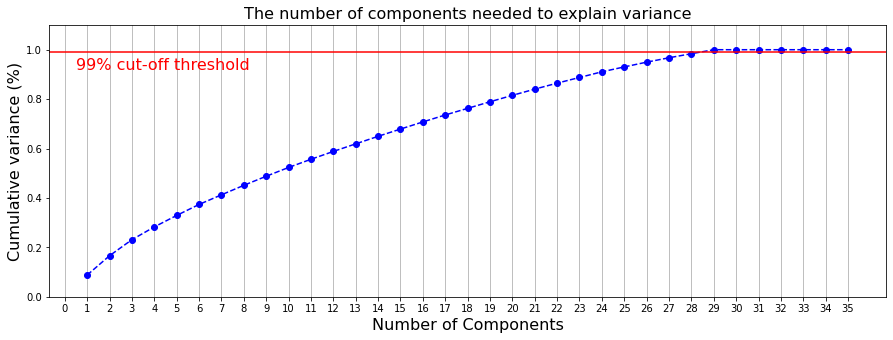

In [196]:
def evaluate_pca_explained_variance(X,scaler=None):
  if scaler is not None:
    X = scaler.fit_transform(X)
  pca = PCA().fit(X)

  fig, ax = plt.subplots()
  xi = np.arange(1, X.shape[1]+1, step=1)
  y = np.cumsum(pca.explained_variance_ratio_)

  plt.rcParams["figure.figsize"] = (15,5)
  plt.ylim(0.0,1.1)
  plt.xlabel('Number of Components', fontsize=16)
  plt.xticks(np.arange(0, 36, step=1)) #change from 0-based array index to 1-based human-readable label
  plt.ylabel('Cumulative variance (%)',fontsize=16)
  plt.title('The number of components needed to explain variance',fontsize=16)
  plt.plot(xi, y, marker='o', linestyle='--', color='b')
  plt.axhline(y=0.99, color='r', linestyle='-')
  plt.text(0.5, 0.92, '99% cut-off threshold', color = 'red', fontsize=16)

  ax.grid(axis='x')
  plt.show()

evaluate_pca_explained_variance(X)

In [197]:
svd = np.linalg.svd
def get_optimal_number_of_components(explainatory_power):
    cov = np.dot(X,X.transpose())/float(X.shape[0])
    U,s,v = svd(cov)
    S_nn = np.cumsum(s)/sum(s)
    return np.sum(S_nn < explainatory_power)

get_optimal_number_of_components(0.99)

28

In [198]:
n_comp = get_optimal_number_of_components(0.99)
print ('optimal number of components = ', n_comp)

pca = PCA(n_components = n_comp)
X_new = pca.fit_transform(features)

optimal number of components =  28


In [199]:
X_new.shape

(1200, 28)

In [200]:
pca = PCA(n_components = 28)
X_train_pca = pca.fit_transform(X)

XX = StandardScaler().fit_transform(X_train_pca)

PCA does not have negative effect on predictions, the Accuracy is exactly the same, but since the size of the dataset is reduced, the training and the optimization time is cut by a significant amount, even though the reduction only compresses 35 dimensions into 20 not to lose classification signal.

# Hyperparameter Tuning

In [201]:
def get_params(space):
  params=[]
  for i in space.keys():
    params.append('param_'+i)
  return np.array(params,dtype=str)

In [203]:
def print_10_best(result):
  params = get_params(space)
  best_10 = result.cv_results_['rank_test_score'] < 10
  for i in range(sum(best_10)):
    print('mean test score:', result.cv_results_['mean_test_score'][best_10][i])
    for param in params:
      print(f'{param}:',result.cv_results_[param][best_10][i])
    print('\n')

In [204]:
# define model
model = LogisticRegression()
# define evaluation
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.linspace(0.001, 100,num=15)
space['multi_class'] = ['ovr']
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='f1_macro', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 90 is smaller than n_iter=500. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Score: 0.5293527699258304
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'ovr', 'C': 7.143785714285714}


Randomized search time: 
- 13:56 on full dataset, accuracy 0.5467
- 1:05  on Dataset Reduced with PCA, accuracy: accuracy 0.5333


In [205]:
print_10_best(result)

mean test score: 0.5293527699258304
param_solver: liblinear
param_penalty: l1
param_C: 7.143785714285714
param_multi_class: ovr


mean test score: 0.5284554261890003
param_solver: newton-cg
param_penalty: l2
param_C: 7.143785714285714
param_multi_class: ovr


mean test score: 0.5284554261890003
param_solver: lbfgs
param_penalty: l2
param_C: 7.143785714285714
param_multi_class: ovr


mean test score: 0.5284554261890003
param_solver: liblinear
param_penalty: l2
param_C: 7.143785714285714
param_multi_class: ovr


mean test score: 0.5293527699258304
param_solver: liblinear
param_penalty: l1
param_C: 14.286571428571428
param_multi_class: ovr


mean test score: 0.5284554261890003
param_solver: newton-cg
param_penalty: l2
param_C: 14.286571428571428
param_multi_class: ovr


mean test score: 0.5284554261890003
param_solver: lbfgs
param_penalty: l2
param_C: 14.286571428571428
param_multi_class: ovr


mean test score: 0.5284554261890003
param_solver: liblinear
param_penalty: l2
param_C: 14.28657

In [231]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

scorer = make_scorer(f1_score, average='macro', greater_is_better=True)

clf = GridSearchCV(LogisticRegression(), {
    'solver': ['lbfgs','liblinear','newton-cg'],
    'penalty': ['l2'],
    'C': np.linspace(0.001, 100,num=150),
    'multi_class': ['ovr']
}, cv=5, return_train_score=False, scoring=scorer)

clf.fit(X_new, y)
best = clf.cv_results_['rank_test_score'] == 1
np.array(clf.cv_results_['params'])[best] 

array([{'C': 8.725744966442953, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'},
       {'C': 9.396879194630872, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'},
       {'C': 10.73914765100671, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'},
       {'C': 10.73914765100671, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'},
       {'C': 11.41028187919463, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'},
       {'C': 11.41028187919463, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'},
       {'C': 11.41028187919463, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'},
       {'C': 12.08141610738255, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'lbfgs'},
       {'C': 12.08141610738255, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'},
       {'C': 12.08141610738255, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg'},
       {'C': 12.752550335570469, 'multi_class': 'ovr', 'penalty': 'l2'

In [238]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.15,train_size=0.85)
model = LogisticRegression(multi_class='ovr', solver = 'liblinear', C=60.403080536912746,penalty='l2')
model.fit(X_tr, y_tr)

LogisticRegression(C=60.403080536912746, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Test:  0.5888888888888889 

[[16  2  1 10  0]
 [ 3 25  1  3  4]
 [ 7  5 11  4  9]
 [ 7  2  2 24  5]
 [ 0  3  4  2 30]] 

              precision    recall  f1-score   support

           0       0.48      0.55      0.52        29
           1       0.68      0.69      0.68        36
           2       0.58      0.31      0.40        36
           3       0.56      0.60      0.58        40
           4       0.62      0.77      0.69        39

    accuracy                           0.59       180
   macro avg       0.58      0.58      0.57       180
weighted avg       0.59      0.59      0.58       180



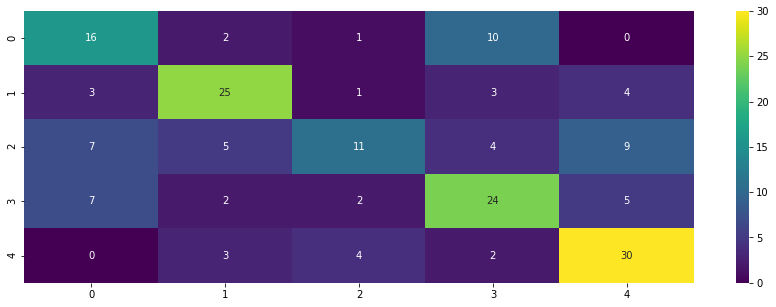

In [239]:
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)),'\n')
print(confusion_matrix(y_te,pred),'\n')
sns.heatmap(confusion_matrix(y_te,pred), annot=True,cmap='viridis')
print(classification_report(y_te,pred))

The Class with highest prediction error is class 2: what is wrong with it?
Let's check 

In [166]:
def get_classification_report(y_test, y_pred):
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    return df_classification_report
    
get_classification_report(y_te, pred)


,precision,recall,f1-score,support
0,0.586207,0.586207,0.586207,29.000000
1,0.545455,0.666667,0.600000,36.000000
2,0.458333,0.261905,0.333333,42.000000
3,0.764706,0.666667,0.712329,39.000000
4,0.551020,0.794118,0.650602,34.000000
accuracy,0.583333,0.583333,0.583333,0.583333
macro avg,0.581144,0.595113,0.576494,180.000000
weighted avg,0.580248,0.583333,0.569452,180.000000


In [167]:
def evaluate_model(features,labels,model,iterations):
  for i in range(iterations-1):
    X_tr, X_te, y_tr, y_te = train_test_split(features, labels, test_size=0.20,train_size=0.80)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    if i == 0:
      report = get_classification_report(y_te,pred)
    report += get_classification_report(y_te,pred).values
  return report/iterations

evaluate_model(features,labels,model,100)

,precision,recall,f1-score,support
0,0.495803,0.480989,0.484719,47.220000
1,0.530939,0.571551,0.546304,45.470000
2,0.448139,0.340334,0.383340,47.230000
3,0.566496,0.563660,0.562565,46.710000
4,0.598272,0.701573,0.642932,53.370000
accuracy,0.533875,0.533875,0.533875,0.533875
macro avg,0.527930,0.531621,0.523972,240.000000
weighted avg,0.533734,0.533875,0.528006,240.000000


In [170]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(labels, classes=[0,1,2,3,4])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=.2)

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

In [171]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.56


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.56')

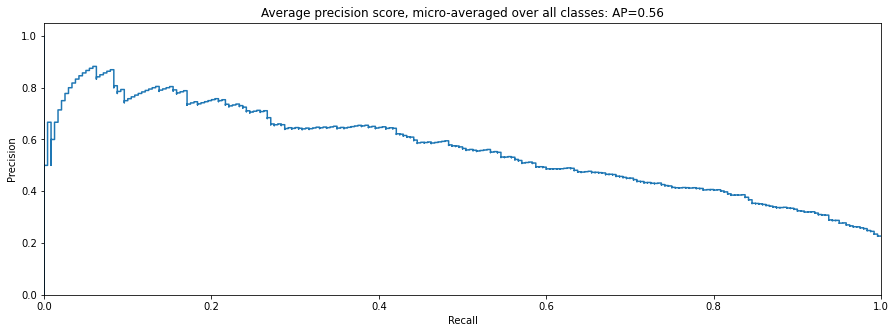

In [172]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

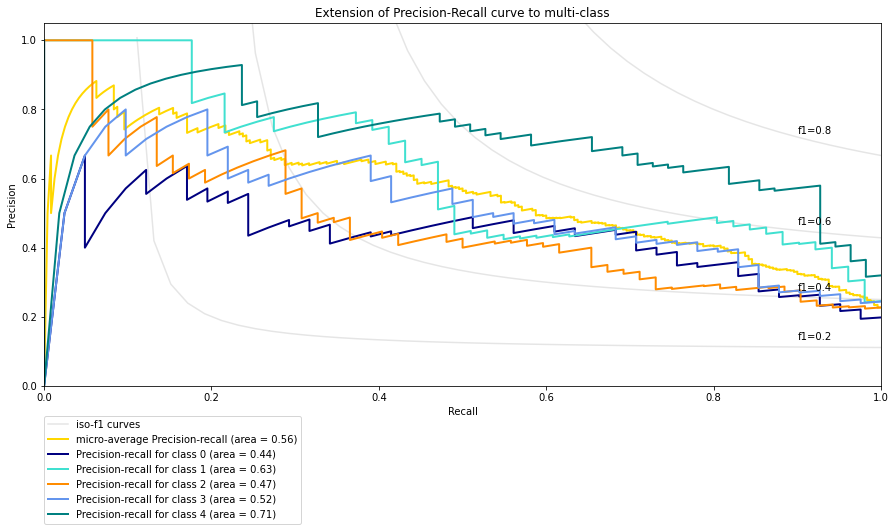

In [173]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(15, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))


plt.show()

# Other models:
- Support Vector Machine
- Extreme Gradient Boost
- Random Forest


In [ ]:
# define model
model = SVC()
# define evaluation
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] =  np.logspace(-3,2,num=15)/2
space['gamma'] = [1,0.1,0.01,0.005,0.001,0.0005,0.0001]
# define search
search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search

print_10_best(result)

Best Score: 0.6958333333333334
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.005, 'C': 21.969852803803974}
mean test score: 0.6958333333333334
param_kernel: rbf
param_C: 21.969852803803974
param_gamma: 0.005


mean test score: 0.5966666666666667
param_kernel: poly
param_C: 0.0005
param_gamma: 0.1


mean test score: 0.5783333333333334
param_kernel: poly
param_C: 0.01341347897639863
param_gamma: 0.1


mean test score: 0.5783333333333334
param_kernel: poly
param_C: 0.15811388300841897
param_gamma: 0.1


mean test score: 0.5783333333333334
param_kernel: poly
param_C: 0.0011379229630373944
param_gamma: 1


mean test score: 0.6958333333333334
param_kernel: rbf
param_C: 50.0
param_gamma: 0.005


mean test score: 0.6224999999999999
param_kernel: poly
param_C: 21.969852803803974
param_gamma: 0.001


mean test score: 0.6083333333333333
param_kernel: rbf
param_C: 1.8637968601574708
param_gamma: 0.01


mean test score: 0.5991666666666667
param_kernel: rbf
param_C: 0.3598428365005761
param_gam

In [ ]:
scorer = make_scorer(accuracy_score, greater_is_better=True)
clf = GridSearchCV(SVC(), {
    'kernel': ['poly','rbf'],
    'C': np.linspace(0.001,100,num=30),
    #'epsilon': [1e-4, 1e-3, 1e-2],
    'gamma': [0.1, 0.01, 0.001]
}, cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7033333333333334
Best Hyperparameters: {'C': 6.89748275862069, 'gamma': 0.001, 'kernel': 'rbf'}


In [119]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.2,train_size=0.8)
model = SVC(kernel='rbf', gamma=0.001, C = 6.89748275862069)
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)))
print(confusion_matrix(y_te,pred))
print(classification_report(y_te,pred))

Test:  0.7
[[38  5  4  2  2]
 [ 1 33  1  5  6]
 [ 3  1 31  2 10]
 [11  5  3 27  1]
 [ 0  5  1  4 39]]
              precision    recall  f1-score   support

           0       0.72      0.75      0.73        51
           1       0.67      0.72      0.69        46
           2       0.78      0.66      0.71        47
           3       0.68      0.57      0.62        47
           4       0.67      0.80      0.73        49

    accuracy                           0.70       240
   macro avg       0.70      0.70      0.70       240
weighted avg       0.70      0.70      0.70       240



In [ ]:
# define model
model = XGBClassifier()
# define evaluation
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['eta'] = np.linspace(0,1,100)
space['max_depth'] = np.logspace(1,2,num=15,dtype=int)//2
space['gamma'] = np.logspace(-5,2)
space['subsample'] = [0.6, 0.8, 1.0]
# define search
search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search
print_10_best(result)

Best Score: 0.6916666666666667
Best Hyperparameters: {'subsample': 0.6, 'max_depth': 8, 'gamma': 0.1, 'eta': 0.8686868686868687}
mean test score: 0.6799999999999999
param_eta: 0.6262626262626263
param_max_depth: 11
param_gamma: 1e-05
param_subsample: 0.8


mean test score: 0.6816666666666666
param_eta: 0.9797979797979799
param_max_depth: 18
param_gamma: 0.1
param_subsample: 0.6


mean test score: 0.6791666666666667
param_eta: 0.14141414141414144
param_max_depth: 8
param_gamma: 0.00026826957952797245
param_subsample: 0.6


mean test score: 0.6899999999999998
param_eta: 0.11111111111111112
param_max_depth: 5
param_gamma: 0.19306977288832497
param_subsample: 0.6


mean test score: 0.6791666666666667
param_eta: 0.4646464646464647
param_max_depth: 8
param_gamma: 0.026826957952797246
param_subsample: 0.6


mean test score: 0.6816666666666666
param_eta: 0.010101010101010102
param_max_depth: 6
param_gamma: 0.19306977288832497
param_subsample: 0.6


mean test score: 0.6791666666666667
param_eta

In [ ]:
scorer = make_scorer(accuracy_score, greater_is_better=True)
clf = GridSearchCV(XGBClassifier(), {
    'eta':[0.6262626,0.97979,0.111111,0.46464,0.010101,0.57575757,0.868686],
    'max_depth' : [11,8,6,5,18,28,40],
    'gamma' : [0.013895,0.1,0.001,0.193,0.0268,0.000268,1e-05,0.01],
    'subsample': [0.6,0.8,0.9]
}, cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6958333333333333
Best Hyperparameters: {'eta': 0.6262626, 'gamma': 1e-05, 'max_depth': 18, 'subsample': 0.6}


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.2,train_size=0.8)
model = XGBClassifier(max_depth=8,eta=0.8,gamma=0.01,subsample=0.6,)
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)))
print(confusion_matrix(y_te,pred))
print(classification_report(y_te,pred))

Test:  0.7333333333333333
[[31  5  1  7  6]
 [ 2 36  1  2  3]
 [ 7  3 25  1  6]
 [ 5  2  1 30  1]
 [ 3  2  4  2 54]]
              precision    recall  f1-score   support

           0       0.65      0.62      0.63        50
           1       0.75      0.82      0.78        44
           2       0.78      0.60      0.68        42
           3       0.71      0.77      0.74        39
           4       0.77      0.83      0.80        65

    accuracy                           0.73       240
   macro avg       0.73      0.73      0.73       240
weighted avg       0.73      0.73      0.73       240



In [ ]:
# define model
model = RandomForestClassifier()
# define evaluation
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['n_estimators'] = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
space['max_features'] = ['auto', 'sqrt']
space['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]
space['bootstrap'] = [True, False]

# define search
search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search
print_10_best(result)

Best Score: 0.7033333333333334
Best Hyperparameters: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
mean test score: 0.7008333333333333
param_n_estimators: 1400
param_max_features: sqrt
param_max_depth: 60
param_min_samples_split: 2
param_min_samples_leaf: 1
param_bootstrap: True


mean test score: 0.6983333333333333
param_n_estimators: 1800
param_max_features: auto
param_max_depth: 70
param_min_samples_split: 5
param_min_samples_leaf: 1
param_bootstrap: True


mean test score: 0.6933333333333334
param_n_estimators: 400
param_max_features: sqrt
param_max_depth: 70
param_min_samples_split: 2
param_min_samples_leaf: 1
param_bootstrap: False


mean test score: 0.6925000000000001
param_n_estimators: 400
param_max_features: sqrt
param_max_depth: 70
param_min_samples_split: 2
param_min_samples_leaf: 2
param_bootstrap: False


mean test score: 0.6933333333333332
param_n_estimators: 800
param_max_features: sqrt


In [ ]:
scorer = make_scorer(accuracy_score, greater_is_better=True)
clf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators':[400,600,800,1200,1400,1600,1800],
    'max_depth' : [40,70,100,110],
    'max_features' : ['sqrt','auto'],
    'min_samples_split': [5,2],
    'min_samples_leaf' : [1,2],
    'bootstrap' : [False]
}, cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, y)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.72
Best Hyperparameters: {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}


In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X_new, labels, test_size=0.2,train_size=0.8)
model = RandomForestClassifier(n_estimators=600, min_samples_split=2, min_samples_leaf=1,max_features='auto',max_depth=100,bootstrap=False )
model.fit(X_tr, y_tr)
pred = model.predict(X_te)
print("Test: ", (accuracy_score(y_te,pred)))
print(confusion_matrix(y_te,pred))
print(classification_report(y_te,pred))

Test:  0.7083333333333334
[[28  3  0  3  6]
 [ 2 29  4  7  4]
 [ 6  5 33  3  7]
 [ 6  2  1 38  6]
 [ 1  1  0  3 42]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.67        40
           1       0.72      0.63      0.67        46
           2       0.87      0.61      0.72        54
           3       0.70      0.72      0.71        53
           4       0.65      0.89      0.75        47

    accuracy                           0.71       240
   macro avg       0.72      0.71      0.71       240
weighted avg       0.72      0.71      0.71       240



In [ ]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(8, input_dim=29, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_new, y, cv=kfold)


In [ ]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# to run

Best parameter (CV score=0.537):
{'logistic__C': 0.49238826317067413, 'pca__n_components': 29}


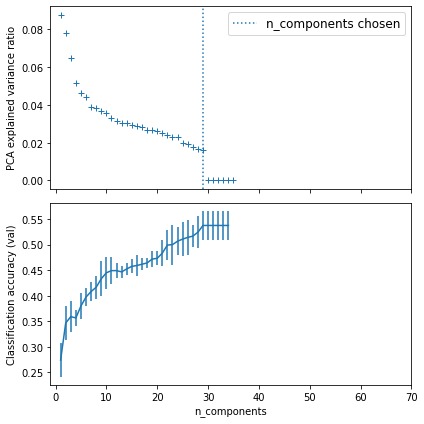

In [240]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': np.arange(1,35),
    'logistic__C': np.logspace(-4, 4, 14),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X, labels)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()
plt.show()